# Multi-modal and multi-vendor retina image registration
## Reimplementation by Olivier Morelle

In [17]:


def mean_phase_image(img):
    return img

def center_crop(img, size):
    center = img.shape[0] // 2, img.shape[1] // 2
    
    height_range = center[0] - size[0] // 2, center[0] + size[0] // 2
    width_range = center[1] - size[1] // 2, center[1] + size[1] // 2
    return img[height_range[0]:height_range[1],
               width_range[0]:width_range[1],
               :]
    

(3456, 3456, 3)

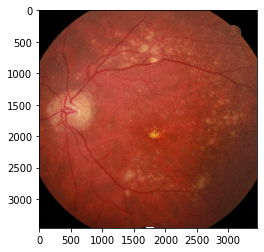

In [20]:
cropped = center_crop(cfp_img, (cfp_img.shape[0], cfp_img.shape[0]))

plt.imshow(cropped)
cropped.shape

In [36]:
import eyepy as ep
import imageio
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure

import numpy as np
from PIL import Image

In [37]:
with ep.io.VolReader("/home/morelle/data/oct_raw/ExportRAWanonymized/67007_20190515.vol") as reader:
    nir_img = reader.read_nir()
    
cfp_img = imageio.imread("/home/morelle/data/oct_raw/ExportRAWanonymized/HS00+0EZ.003.BMP")
cfp_img = center_crop(cfp_img, (cfp_img.shape[0], cfp_img.shape[0]))


im = Image.fromarray(cfp_img)
im.thumbnail(nir_img.shape, Image.ANTIALIAS)

cfp_img = np.array(im)

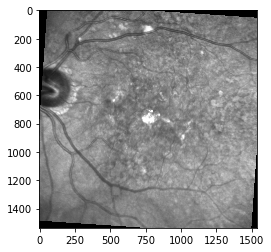

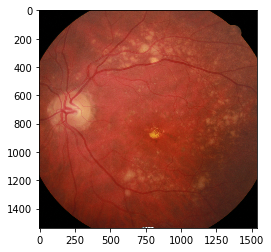

In [38]:
plt.imshow(nir_img, cmap="gray")
plt.show()
plt.imshow(cfp_img, cmap="gray")
plt.show()

In [56]:
fd_nir, nir_hog = hog(nir_img, orientations=12, pixels_per_cell=(3, 3),
                    cells_per_block=(11, 11), visualize=True, multichannel=False)


fd_hog, cfp_hog = hog(cfp_img[..., 1], orientations=12, pixels_per_cell=(3, 3),
                    cells_per_block=(11, 11), visualize=True, multichannel=False)

(-0.5, 1535.5, 1535.5, -0.5)

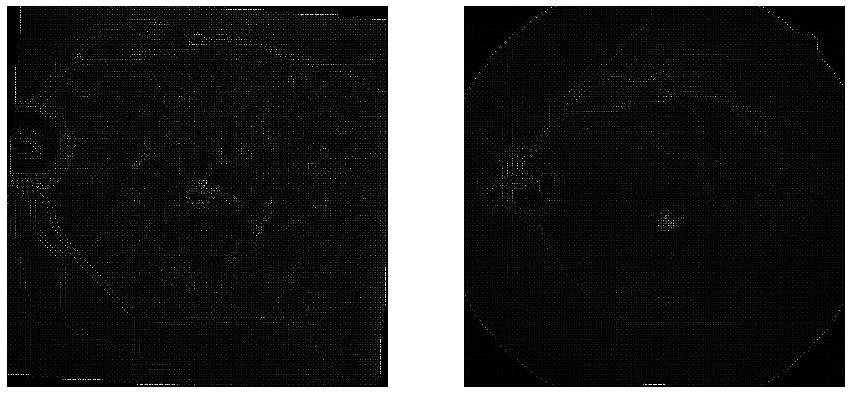

In [58]:
nir_hog_image = exposure.rescale_intensity(nir_hog, in_range=(0, 10))
cfp_hog_image = exposure.rescale_intensity(cfp_hog, in_range=(0, 10))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10), sharex=True, sharey=True)
ax1.imshow(nir_hog_image, cmap="gray")
ax2.imshow(cfp_hog_image, cmap="gray")

ax1.axis("off")
ax2.axis("off")

(1536, 1536)